<a href="https://colab.research.google.com/github/mykhailodolitsoi/KPI_NN/blob/master/KPI_nn_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# setup the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
# create the data
torch.manual_seed(0)

x = torch.linspace(0, 15, 1000).view(-1, 1)
y = (np.cos(x) + np.sin(x)).view(-1, 1)

x = x.detach().clone()
y = y.detach().clone()

print(x[:5], y[:5])

tensor([[0.0000],
        [0.0150],
        [0.0300],
        [0.0450],
        [0.0601]]) tensor([[1.0000],
        [1.0149],
        [1.0296],
        [1.0440],
        [1.0582]])


/tmp/ipython-input-3163589742.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (np.cos(x) + np.sin(x)).view(-1, 1)


In [3]:
# train/test split
train_size = int(0.8 * len(x))

x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([800, 1]) torch.Size([800, 1]) torch.Size([200, 1]) torch.Size([200, 1])


In [4]:
# best activation function
class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

In [5]:
# feed forward nn
class FFNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out

In [6]:
# cascade forward nn
class CFNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CFNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.layers = nn.ModuleList()
        current_input_dim = input_size

        for h_size in hidden_sizes:
            self.layers.append(nn.Linear(current_input_dim, h_size))
            current_input_dim += h_size

        self.output_layer = nn.Linear(current_input_dim, output_size)
        self.activation = Sin()

    def forward(self, x):
        activations = [x]
        current_input = x

        for layer in self.layers:
            out = self.activation(layer(current_input))
            activations.append(out)
            current_input = torch.cat(activations, dim=1)

        out = self.output_layer(current_input)
        return out

In [7]:
# elman nn
class ENN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(ENN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.layers = nn.ModuleList()
        self.activation = Sin()

        for i, h_size in enumerate(hidden_sizes):
            prev_size = input_size if i == 0 else hidden_sizes[i-1]
            self.layers.append(nn.Linear(prev_size + h_size, h_size))

        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = 1

        hidden_states = [
            torch.zeros(batch_size, h_size)
            for h_size in self.hidden_sizes
        ]

        inp = x
        for i, layer in enumerate(self.layers):
            combined = torch.cat((inp, hidden_states[i]), dim=1)
            hidden_states[i] = self.activation(layer(combined))
            inp = hidden_states[i]

        out = self.output_layer(hidden_states[-1])
        return out

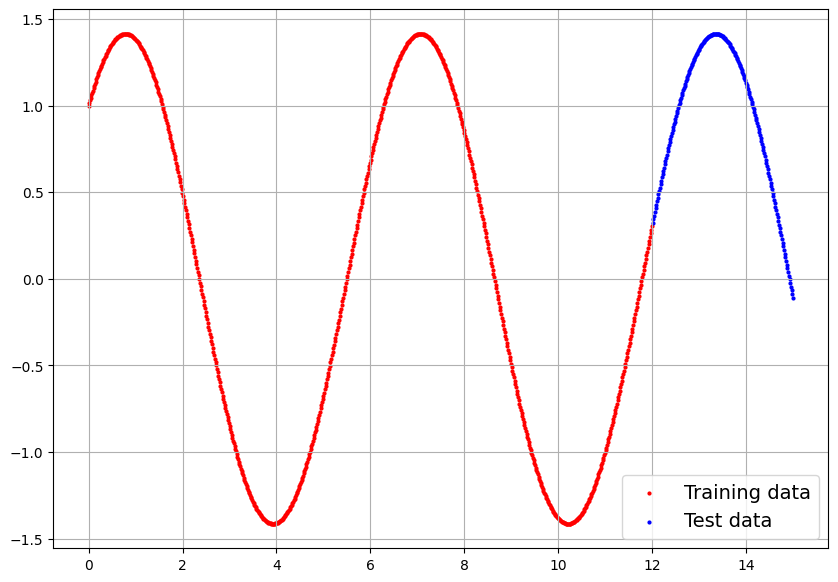

In [8]:
def plot_predictions(train_data = x_train,
                     train_labels = y_train,
                     test_data = x_test,
                     test_labels = y_test,
                     predictions = None):
    plt.figure(figsize = (10, 7))

    plt.scatter(train_data, train_labels, c="r", s=4, label="Training data")

    plt.scatter(test_data, test_labels, c="b", s=4, label="Test data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="g", s=4, label="Predictions")

    plt.legend(prop={"size": 14})
    plt.grid()

plot_predictions()

In [15]:
def train(model = None):
    epochs = 7000

    loss_fn = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(params = model.parameters(), lr=0.005)

    epoch_count = []
    loss_values = []
    test_loss_values = []

    for epoch in range(epochs):
        model.train()

        y_pred = model(x_train)

        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_pred = model(x_test)

            test_loss = loss_fn(test_pred, y_test)

        if epoch % 100 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)
            print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

    plot_predictions(predictions=test_pred.detach().numpy())

In [16]:
torch.manual_seed(0)

ff_1 = FFNN([nn.Linear(1, 10), Sin(), nn.Linear(10, 1)])
ff_2 = FFNN([nn.Linear(1, 20), Sin(), nn.Linear(20, 1)])

cf_1 = CFNN(1, [20], 1);
cf_2 = CFNN(1, [10, 10], 1);

r_1 = ENN(1, [15], 1)
r_2 = ENN(1, [5, 5, 5], 1)

Epoch: 0 | Train loss: 0.9670355916023254 | Test loss: 0.6412508487701416
Epoch: 100 | Train loss: 0.05313810333609581 | Test loss: 0.6251817941665649
Epoch: 200 | Train loss: 0.027752738445997238 | Test loss: 0.3674788773059845
Epoch: 300 | Train loss: 0.022864647209644318 | Test loss: 0.18749016523361206
Epoch: 400 | Train loss: 0.015084232203662395 | Test loss: 0.15641777217388153
Epoch: 500 | Train loss: 0.012747416272759438 | Test loss: 0.10887126624584198
Epoch: 600 | Train loss: 0.014528878964483738 | Test loss: 0.08686087280511856
Epoch: 700 | Train loss: 0.017268264666199684 | Test loss: 0.05095775052905083
Epoch: 800 | Train loss: 0.01009313017129898 | Test loss: 0.035436950623989105
Epoch: 900 | Train loss: 0.006341532338410616 | Test loss: 0.042458370327949524
Epoch: 1000 | Train loss: 0.006107398774474859 | Test loss: 0.03854583576321602
Epoch: 1100 | Train loss: 0.01412951573729515 | Test loss: 0.05126389116048813
Epoch: 1200 | Train loss: 0.0071134972386062145 | Test los

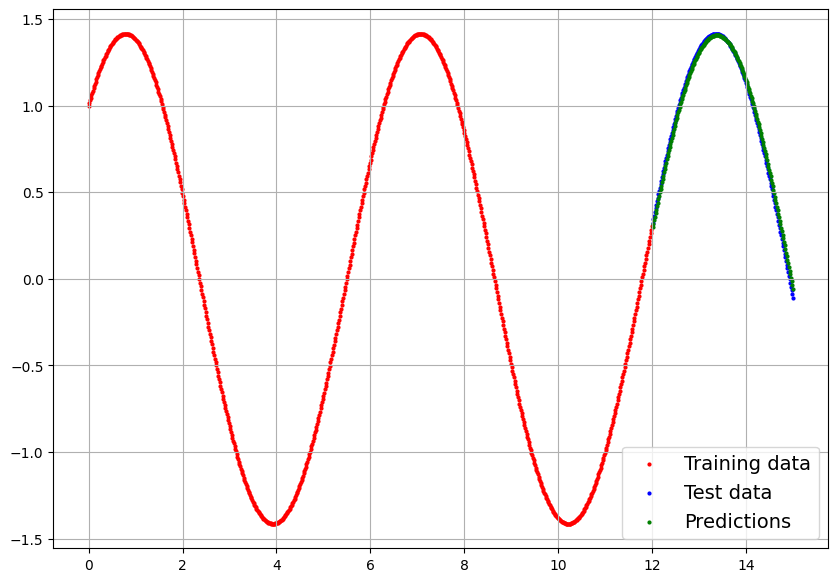

In [76]:
train(ff_1)

Epoch: 0 | Train loss: 0.9644967913627625 | Test loss: 1.0653616189956665
Epoch: 100 | Train loss: 0.026088640093803406 | Test loss: 0.32043880224227905
Epoch: 200 | Train loss: 0.019001498818397522 | Test loss: 0.342823326587677
Epoch: 300 | Train loss: 0.016731776297092438 | Test loss: 0.36533230543136597
Epoch: 400 | Train loss: 0.013770065270364285 | Test loss: 0.3722306489944458
Epoch: 500 | Train loss: 0.02057630382478237 | Test loss: 0.3950662314891815
Epoch: 600 | Train loss: 0.01277840044349432 | Test loss: 0.3687184453010559
Epoch: 700 | Train loss: 0.013651101849973202 | Test loss: 0.3932977616786957
Epoch: 800 | Train loss: 0.01117879617959261 | Test loss: 0.3289782702922821
Epoch: 900 | Train loss: 0.010490328073501587 | Test loss: 0.31779003143310547
Epoch: 1000 | Train loss: 0.008525014854967594 | Test loss: 0.31511324644088745
Epoch: 1100 | Train loss: 0.011708978563547134 | Test loss: 0.28605496883392334
Epoch: 1200 | Train loss: 0.006130062509328127 | Test loss: 0.293

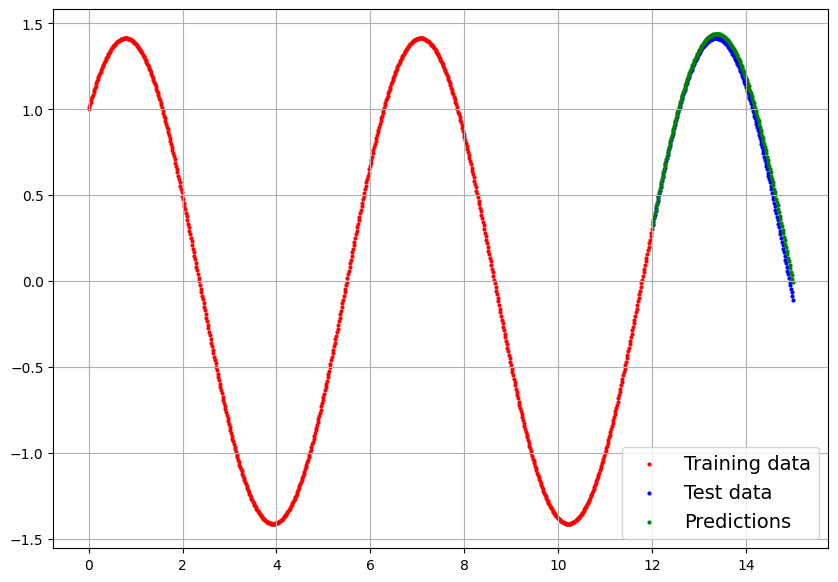

In [77]:
train(ff_2)

Epoch: 0 | Train loss: 0.8526963591575623 | Test loss: 2.8751087188720703
Epoch: 100 | Train loss: 0.01936778798699379 | Test loss: 0.2112993448972702
Epoch: 200 | Train loss: 0.012878995388746262 | Test loss: 0.1000344529747963
Epoch: 300 | Train loss: 0.018793435767292976 | Test loss: 0.07499781250953674
Epoch: 400 | Train loss: 0.013997213914990425 | Test loss: 0.0062632085755467415
Epoch: 500 | Train loss: 0.019483905285596848 | Test loss: 0.02144189551472664
Epoch: 600 | Train loss: 0.008339231833815575 | Test loss: 0.05240669101476669
Epoch: 700 | Train loss: 0.010049128904938698 | Test loss: 0.043154630810022354
Epoch: 800 | Train loss: 0.007299432530999184 | Test loss: 0.034082453697919846
Epoch: 900 | Train loss: 0.009251228533685207 | Test loss: 0.013332408852875233
Epoch: 1000 | Train loss: 0.009625219739973545 | Test loss: 0.020369913429021835
Epoch: 1100 | Train loss: 0.008010701276361942 | Test loss: 0.007719486486166716
Epoch: 1200 | Train loss: 0.011986471712589264 | Te

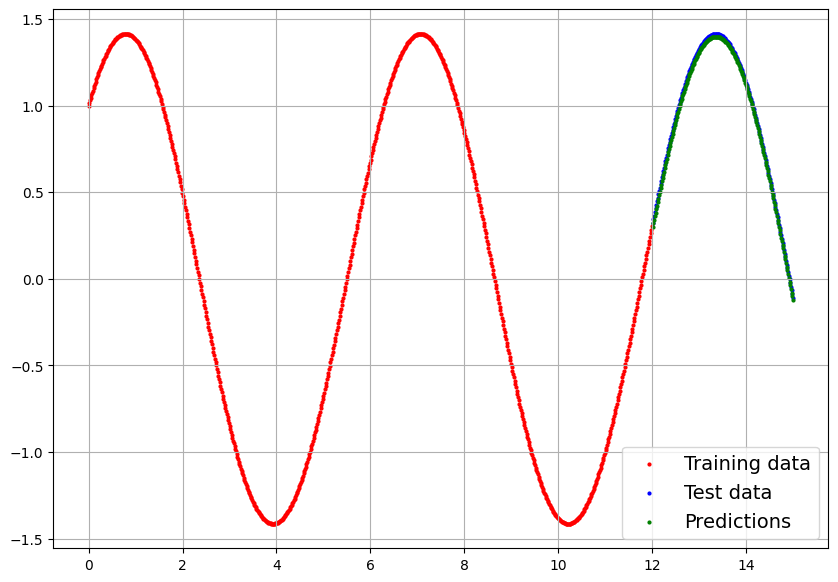

In [78]:
train(cf_1)

Epoch: 0 | Train loss: 0.7932466268539429 | Test loss: 2.031280755996704
Epoch: 100 | Train loss: 0.024156255647540092 | Test loss: 0.24964585900306702
Epoch: 200 | Train loss: 0.033232998102903366 | Test loss: 0.20030559599399567
Epoch: 300 | Train loss: 0.01935175247490406 | Test loss: 0.15724219381809235
Epoch: 400 | Train loss: 0.012536397203803062 | Test loss: 0.20597435534000397
Epoch: 500 | Train loss: 0.01834058202803135 | Test loss: 0.2077980488538742
Epoch: 600 | Train loss: 0.012980138882994652 | Test loss: 0.21697896718978882
Epoch: 700 | Train loss: 0.01336057297885418 | Test loss: 0.23870591819286346
Epoch: 800 | Train loss: 0.006686843000352383 | Test loss: 0.22305840253829956
Epoch: 900 | Train loss: 0.015996471047401428 | Test loss: 0.24305418133735657
Epoch: 1000 | Train loss: 0.014060544781386852 | Test loss: 0.22162070870399475
Epoch: 1100 | Train loss: 0.008958029560744762 | Test loss: 0.22885608673095703
Epoch: 1200 | Train loss: 0.01721339300274849 | Test loss: 0

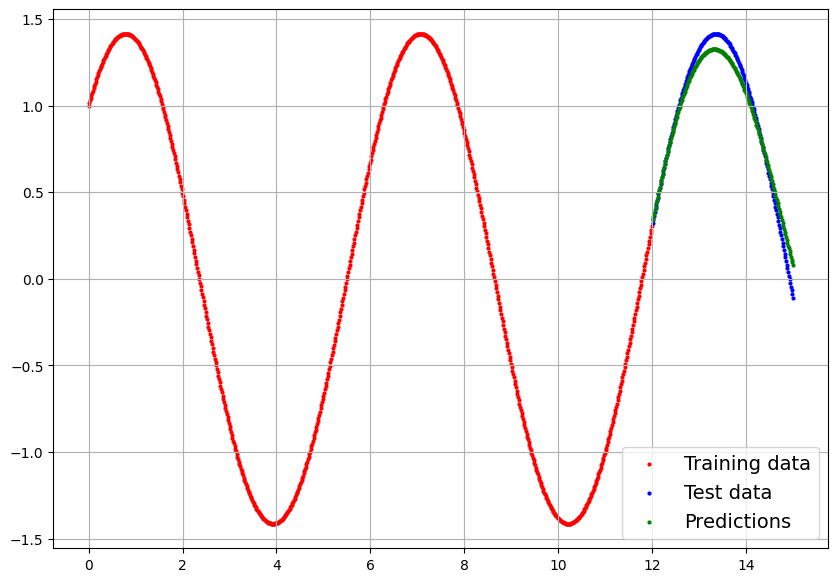

In [79]:
train(cf_2)

Epoch: 0 | Train loss: 0.8989807367324829 | Test loss: 1.3333179950714111
Epoch: 100 | Train loss: 0.36096227169036865 | Test loss: 2.2950048446655273
Epoch: 200 | Train loss: 0.14861361682415009 | Test loss: 1.1235030889511108
Epoch: 300 | Train loss: 0.017781557515263557 | Test loss: 0.07173170149326324
Epoch: 400 | Train loss: 0.021380586549639702 | Test loss: 0.06568729132413864
Epoch: 500 | Train loss: 0.009023139253258705 | Test loss: 0.01925567351281643
Epoch: 600 | Train loss: 0.012108364142477512 | Test loss: 0.042939443141222
Epoch: 700 | Train loss: 0.014609980396926403 | Test loss: 0.010810746811330318
Epoch: 800 | Train loss: 0.013392086140811443 | Test loss: 0.016124770045280457
Epoch: 900 | Train loss: 0.010324916802346706 | Test loss: 0.023292968049645424
Epoch: 1000 | Train loss: 0.0077659208327531815 | Test loss: 0.04091043025255203
Epoch: 1100 | Train loss: 0.020887579768896103 | Test loss: 0.014238458126783371
Epoch: 1200 | Train loss: 0.008090145885944366 | Test lo

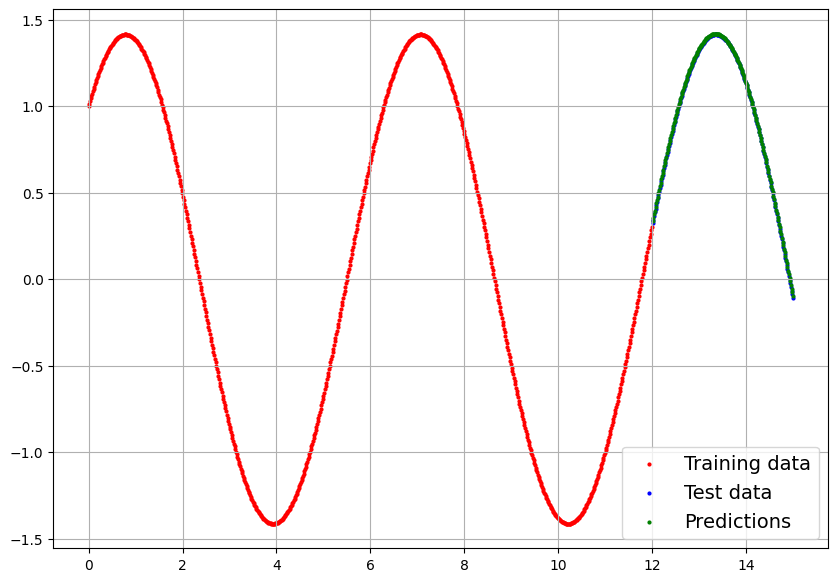

In [80]:
train(r_1)

Epoch: 0 | Train loss: 0.9285160303115845 | Test loss: 1.1326597929000854
Epoch: 100 | Train loss: 0.21615122258663177 | Test loss: 2.2148096561431885
Epoch: 200 | Train loss: 0.06294333189725876 | Test loss: 1.5205140113830566
Epoch: 300 | Train loss: 0.05918843671679497 | Test loss: 0.30944302678108215
Epoch: 400 | Train loss: 0.02290358580648899 | Test loss: 0.2461417019367218
Epoch: 500 | Train loss: 0.03999568521976471 | Test loss: 0.23167534172534943
Epoch: 600 | Train loss: 0.0207537654787302 | Test loss: 0.2560826241970062
Epoch: 700 | Train loss: 0.017599178478121758 | Test loss: 0.2586860656738281
Epoch: 800 | Train loss: 0.021004946902394295 | Test loss: 0.2688441872596741
Epoch: 900 | Train loss: 0.016375767067074776 | Test loss: 0.2693980038166046
Epoch: 1000 | Train loss: 0.016463665291666985 | Test loss: 0.27617016434669495
Epoch: 1100 | Train loss: 0.01293846033513546 | Test loss: 0.26466357707977295
Epoch: 1200 | Train loss: 0.015054894611239433 | Test loss: 0.28543099

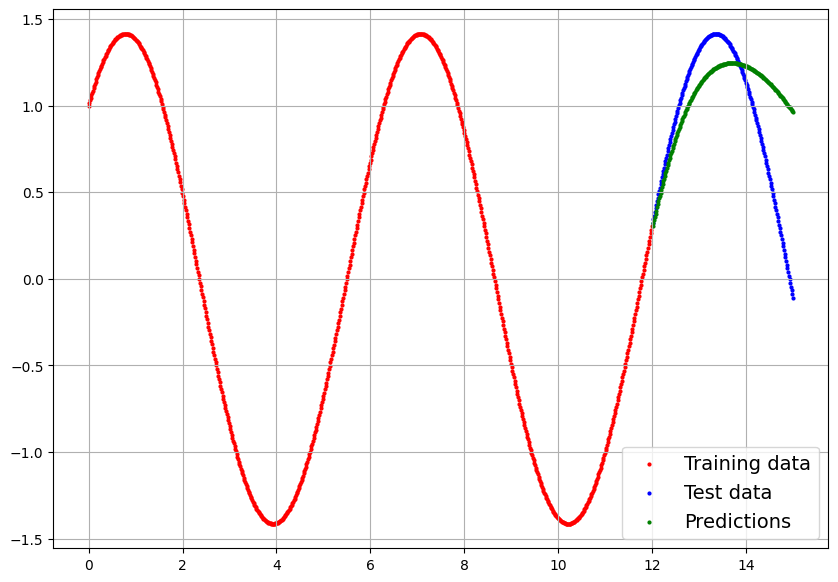

In [17]:
train(r_2)